# Research Experiments on the effect of parent Selection on Generalization for symbolic Regression in GP

## Tournament Selection

* Masterseminar: SoSe 2022
* JGU Mainz
* FB 03 Recht-und Wirtschaftswissenschaften
* Lehrstuhl für Wirtschaftsinformatik und BWL

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import operator
from deap import gp, tools, creator, base, algorithms
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Callable
import math
from random import randint


## Energy efficiency Data Set

Source: https://archive.ics.uci.edu/ml/datasets/energy+efficiency

In [2]:
# (re-)download file to ./data

# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx -P ./data

In [3]:
D_PATH = "data/ENB2012_data.xlsx"

# TODO: research optimal splitsize!
TRAINING_D_SPLITSIZE = 0.5

def get_dataSets(datapath: str, train_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Read (excel) dataset at <datapath> and return two randomly split DFs for training/testing"""
    df = pd.read_excel(datapath)
    return train_test_split(df, train_size=train_size, test_size=(1-train_size))    

trainDF, testDF = get_dataSets(D_PATH, TRAINING_D_SPLITSIZE)

In [4]:
trainDF.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
179,0.69,735.0,294.0,220.5,3.5,5,0.10,3,11.14,14.40
599,0.76,661.5,416.5,122.5,7.0,5,0.40,2,40.42,39.70
474,0.64,784.0,343.0,220.5,3.5,4,0.25,4,16.56,20.37
127,0.71,710.5,269.5,220.5,3.5,5,0.10,2,10.68,14.21
462,0.71,710.5,269.5,220.5,3.5,4,0.25,4,12.17,15.20


In [5]:
trainDF.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,0.760000,675.153646,318.053385,178.550130,5.186198,3.473958,0.235677,2.783854,22.104557,24.329974
std,0.104444,87.424162,44.347228,44.788201,1.751118,1.109818,0.136883,1.564171,10.042611,9.453585
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.010000,10.900000
25%,0.660000,612.500000,294.000000,147.000000,3.500000,2.750000,0.100000,1.750000,12.950000,15.567500
50%,0.740000,686.000000,318.500000,220.500000,3.500000,3.000000,0.250000,3.000000,18.175000,21.365000
75%,0.820000,759.500000,343.000000,220.500000,7.000000,4.000000,0.400000,4.000000,31.652500,32.842500
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,43.100000,48.030000


## Data Visualization

In [6]:
from matplotlib import pyplot as plt
import networkx as nx
import pygraphviz as pgv

%matplotlib inline

def plot_exprTree(expr_tree, title:str) -> None:
    """plots an expression tree"""
    nodes, edges, labels = gp.graph(expr_tree)

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)

    plt.title(title)
    plt.show()

## GP System Setup

### Primitive set

In [7]:
UVS = {
    "ARG0" : "X1",
    "ARG1" : "X2",
    "ARG2" : "X3",
    "ARG3" : "X4",
    "ARG4" : "X5",
    "ARG5" : "X6",
    "ARG6" : "X7",
    "ARG7" : "X8",
}

# register the Primitive Set
pset = gp.PrimitiveSet("MAIN", arity=len(UVS))

# rename ARGS to match the dataset
for arg, des in UVS.items():
    pset.renameArguments(arg=des)


In [8]:
# adding functions

def saveDiv(lhs, rhs) -> float:
    """
    GP-save implementation of Division
    [@poli08:fieldguide, p.22]
    """
    if rhs == 0:
        return 1
    return lhs / rhs


operators = (
    (operator.add, 2),
    (operator.sub, 2),
    (operator.mul, 2),
    (saveDiv, 2),
    (math.sin, 1),
    (math.cos, 1),
    # FIXME: (math.exp, 1),
    # FIXME: (math.log, 1),
    (operator.neg, 1)
)

for (func, arity) in operators:
    pset.addPrimitive(func, arity)

pset.addEphemeralConstant("rand1", lambda: randint(-1,1))

### Custom Types

In [9]:
# min fitness object

# objective: minimize MAD for y1

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))


In [10]:
# individuals program
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

## GP SPecs

In [11]:
# TODO: research alternatives

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [12]:
# fitness function for all fitness case:
def evaluate_df_y1_symReg (individual:creator.Individual, df:pd.core.frame.DataFrame) -> tuple[float]:
    """
    Evaluates an individual program for all fitness cases (=rows of pd.dataframe) inside the dataframe, computes and returns the mean absolute error for prediction and outcome for y1 and model prediction
    """
    # Transform the tree expression in a callable function
    compiled_individual = toolbox.compile(expr=individual)

    def evaluate_single_case_y1_symReg(func:Callable, case:pd.core.series.Series) -> float:
        """
        Evaluates an individual, compiled program for a single fitness case (=row of pd.dataframe), computes and returns the absolute error for prediction and outcome for y1 and model prediction
        """
        # compute individual with case variables
        y1_prediction = func(*case[0:8:].values)

        # optimal value:
        y1_value = case[8:9:].values[0]

        # compute absolute difference and return
        abs_error = abs(y1_prediction - y1_value)
        return (abs_error)
    
    n = len(df)
    abs_error_aggregate = 0.0

    # iterate through all fitness cases and aggregate absolute errors
    for _, fitness_case in df.iterrows():
        abs_error_aggregate += evaluate_single_case_y1_symReg(func=compiled_individual, case=fitness_case)
    
    # compute and return MAE
    mean_absolute_error = abs_error_aggregate / n
    return (mean_absolute_error, )


In [13]:
# GP system setup

toolbox.register("evaluate", evaluate_df_y1_symReg, df=trainDF)

# registration:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# decoration:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

## Statistics

In [14]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [15]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min    	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	2952.93	0  	465823	6.89867	300   	28644.9	3.48667	0  	7  	2  	300   	1.51542
1  	169   	85.2108	1  	8747.41	6.89867	169   	532.146	3.41   	1  	10 	1  	169   	1.45209
2  	170   	67.0706	2  	3462.67	6.89867	170   	279.078	3.68333	2  	13 	1  	170   	1.73678
3  	166   	130.196	3  	17575.5	6.65289	166   	1072.51	4.05667	3  	17 	1  	166   	1.93222
4  	182   	56.0418	4  	2014.95	6.65289	182   	236.232	3.98667	4  	17 	1  	182   	1.77571
5  	164   	239.421	5  	57325.7	6.06753	164   	3321.62	3.74333	5  	12 	1  	164   	1.60545
6  	162   	36.9664	6  	1723.51	6.03665	162   	176.194	3.80333	6  	10 	1  	162   	1.48705


KeyboardInterrupt: 

mul(add(add(add(add(ARG4, sin(ARG5)), saveDiv(ARG0, add(add(add(ARG4, sin(ARG5)), saveDiv(sin(ARG5), add(ARG5, ARG0))), ARG0))), 0), 0), add(add(ARG5, sin(mul(ARG5, ARG0))), sin(add(add(add(add(ARG4, saveDiv(ARG0, ARG1)), 0), 0), 0))))


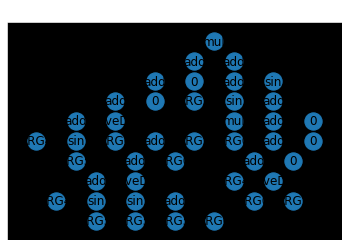

In [ ]:

for elite in hof:
    winner = elite
    print (elite)
    plot_exprTree(elite, "Best Solution")

In [ ]:
winner_func = gp.compile(winner, pset)

abs_err_agg = 0.0
n = len(testDF)

for _, case in testDF.iterrows():
    abs_err_agg += abs(winner_func(*case[0:8:].values) - case[8:9:].values[0])

MAE = abs_err_agg / n

print("Mean absolute error for unknown Dataset = ", MAE)

Mean absolute error for unknown Dataset =  3.5887379721633565
